In [ ]:
# Unified data ingest with optional subset/caching so we can iterate quickly
import re
from pathlib import Path
import pandas as pd
import numpy as np

HERE = Path.cwd().resolve()
PROJECT_ROOT = HERE.parent
RAW_PATH = PROJECT_ROOT / "data/arrets_ben.csv"
SMALL_SAMPLE_PATH = PROJECT_ROOT / "data/oct2024.csv"
PARQUET_CACHE = PROJECT_ROOT / "arrets_ben.parquet"
USE_SMALL_SAMPLE = False   # flip to False when you want the full month
FORCE_REBUILD_PARQUET = False

def _read_full_fixed_width(path: Path) -> pd.DataFrame:
    """Read the raw fixed-width export once (≈10 min) and return a clean dataframe."""
    with path.open(encoding="utf-8-sig") as f:
        header_line = f.readline().rstrip("\n")
        dash_line = f.readline().rstrip("\n")
    colspecs = [(m.start(), m.end()) for m in re.finditer(r"-+", dash_line)]
    colspecs[-1] = (colspecs[-1][0], None)
    raw_names = [header_line[s:] if e is None else header_line[s:e] for s, e in colspecs]
    names, seen = [], {}
    for nm in map(str.strip, raw_names):
        seen[nm] = seen.get(nm, -1) + 1
        names.append(nm if seen[nm] == 0 else f"{nm}_{seen[nm]}")
    df_full = pd.read_fwf(
        path, colspecs=colspecs, names=names, skiprows=2, na_values=["NULL"], encoding="utf-8-sig"
    )
    print(f"[FWF] detected {len(names)} columns, shape={df_full.shape}")
    return df_full

if USE_SMALL_SAMPLE and SMALL_SAMPLE_PATH.exists():
    df = pd.read_csv(SMALL_SAMPLE_PATH, low_memory=False)
    print(f"Loaded subset {SMALL_SAMPLE_PATH.relative_to(PROJECT_ROOT)} -> {df.shape}")
else:
    if PARQUET_CACHE.exists() and not FORCE_REBUILD_PARQUET:
        try:
            df = pd.read_parquet(PARQUET_CACHE)
            print(f"Loaded cached parquet {PARQUET_CACHE.relative_to(PROJECT_ROOT)} -> {df.shape}")
        except Exception as exc:
            print(f"Parquet load failed ({exc}); falling back to raw file.")
            df = _read_full_fixed_width(RAW_PATH)
    else:
        df = _read_full_fixed_width(RAW_PATH)
        try:
            df.to_parquet(PARQUET_CACHE, index=False)
            print(f"Cached parquet to {PARQUET_CACHE}")
        except Exception as exc:
            print(f"Parquet export skipped: {exc}")
            
df = df[df['C_TypeAppl'] == 0]
print(df.head(3))

[FWF] detected 73 columns, shape=(2301409, 73)
Parquet export skipped: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.
   IdCourse  IdArret  RangArretAsc  DateCourse HDepartTheo HArriveeTheo  \
0  83748979      261             1  2024-10-01    16:59:00     16:59:00   
1  83748853      261             1  2024-10-01    06:31:00     06:31:00   
4  83748928      702             1  2024-10-01    05:09:00     05:09:00   

   DistanceTheo  TempsInterArretTheo  EcartDepart  EcartDistance  ...  \
0             0                    0           58              0  ...   
1             0             

In [70]:
# =========================
# Build `seg` (prev stop -> current stop) from df 
# =========================
import numpy as np
import pandas as pd

seg_src = df.copy()

# --- 0) Parse datetimes ---
time_cols = [
    "DTDepartTheo","DTArriveeTheo", # Keep for fallback anchor
    "DTEntreeFenetreArretReal","DTSortieFenetreArretReal",
    "DTEntreeArretAtp","DTSortieArretAtp",
]
for c in time_cols:
    if c in seg_src.columns:
        seg_src[c] = pd.to_datetime(seg_src[c], errors="coerce")

# --- 1) Basic casting / trimming ---
if "RangArretAsc" in seg_src.columns:
    seg_src["RangArretAsc"] = pd.to_numeric(seg_src["RangArretAsc"], errors="coerce")
if "C_Ligne" in seg_src.columns:
    seg_src["C_Ligne"] = pd.to_numeric(seg_src["C_Ligne"], errors="coerce")
seg_src["CodeLong"] = seg_src.get("CodeLong", "").astype(str).str.strip()
if "C_SensAppl" in seg_src.columns:
    seg_src["C_SensAppl"] = seg_src["C_SensAppl"].astype(str).str.strip()
for c in ["DistanceInterArret","TempsInterArretRealise","EcartDepart","NbMontees","NbDescentes"]:
    if c in seg_src.columns:
        seg_src[c] = pd.to_numeric(seg_src[c], errors="coerce")

# --- 2) Sort and build previous-stop columns (within a trip/course) ---
by = ["IdCourse","RangArretAsc"] if "IdCourse" in seg_src.columns else ["C_Ligne","DateCourse","RangArretAsc"]
seg_src = seg_src.sort_values(by, kind="mergesort")
grp = seg_src.groupby("IdCourse") if "IdCourse" in seg_src.columns else seg_src.groupby(["C_Ligne","DateCourse"])

seg_src["prev_CodeLong"] = grp["CodeLong"].shift(1)

# previous-window exit
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg_src.columns):
    seg_src["prev_DT_win_out"] = grp["DTSortieFenetreArretReal"].shift(1)
    seg_src["prev_DT_win_in"]  = grp["DTEntreeFenetreArretReal"].shift(1)
else:
    seg_src["prev_DT_win_out"] = np.nan
    seg_src["prev_DT_win_in"]  = np.nan

# fallbacks
seg_src["prev_DT_atp_in"]   = grp["DTEntreeArretAtp"].shift(1) if "DTEntreeArretAtp" in seg_src.columns else np.nan
seg_src["prev_DT_sched_dep"]= grp["DTDepartTheo"].shift(1)     if "DTDepartTheo" in seg_src.columns else np.nan

# upstream demand / punctuality
for c in ["NbMontees","NbDescentes","EcartDepart"]:
    if c in seg_src.columns:
        seg_src[f"prev_{c}"] = grp[c].shift(1)
        # ### --- CORRECTION FOR MOMENTUM --- ###
        # Create the 2-hop lag on the *same dataframe*
        if c == "EcartDepart":
             seg_src[f"prev_prev_{c}"] = grp[c].shift(2)

# --- 3) Keep only rows that have a previous stop (i.e., valid link) ---
seg = seg_src.dropna(subset=["prev_CodeLong"]).copy()
seg["from_stop"] = seg["prev_CodeLong"].astype(str).str.strip()
seg["to_stop"]   = seg["CodeLong"].astype(str).str.strip()
seg["SegmentKey"] = seg["from_stop"] + "→" + seg["to_stop"]

# --- 4) Targets from single sources ---
# 4a) Link Target
seg["link_s"] = seg.get("TempsInterArretRealise")
seg.loc[(seg["link_s"]<=0) | (seg["link_s"]>1800), "link_s"] = np.nan

# 4b) Dwell Target (and 1-hop / 2-hop features)
if {"DTEntreeFenetreArretReal","DTSortieFenetreArretReal"}.issubset(seg.columns):
    seg["dwell_s"] = (seg["DTSortieFenetreArretReal"] - seg["DTEntreeFenetreArretReal"]).dt.total_seconds()
    seg.loc[(seg["dwell_s"]<0) | (seg["dwell_s"]>900), "dwell_s"] = np.nan
    
    # We must re-group on the 'seg' dataframe to lag dwell
    grp_seg = seg.groupby("IdCourse") if "IdCourse" in seg.columns else seg.groupby(["C_Ligne","DateCourse"])
    seg["dwell_prev_s"] = grp_seg["dwell_s"].shift(1)
    seg["dwell_prev_prev_s"] = grp_seg["dwell_s"].shift(2)
else:
    seg["dwell_s"] = np.nan
    seg["dwell_prev_s"] = np.nan
    seg["dwell_prev_prev_s"] = np.nan
    
seg.loc[(seg["dwell_prev_s"]<0) | (seg["dwell_prev_s"]>900), "dwell_prev_s"] = np.nan
seg.loc[(seg["dwell_prev_prev_s"]<0) | (seg["dwell_prev_prev_s"]>900), "dwell_prev_prev_s"] = np.nan

# 4c) Punctuality signals (and 1-hop / 2-hop / momentum features)
seg["E_i"]    = pd.to_numeric(seg.get("EcartDepart"), errors="coerce")
seg["E_prev"] = pd.to_numeric(seg.get("prev_EcartDepart"), errors="coerce")

# ### --- CORRECTION FOR MOMENTUM --- ###
# Now we use the correctly-aligned 2-hop lag column
seg["E_prev_prev"] = pd.to_numeric(seg.get("prev_prev_EcartDepart"), errors="coerce")
seg["momentum_s"] = seg["E_prev"] - seg["E_prev_prev"]
seg["momentum_s"] = seg["momentum_s"].fillna(0) # Fill first 2 stops (NaNs) with 0 momentum

# --- 5) Upstream demand (1-hop) ---
seg["board_prev"]  = pd.to_numeric(seg.get("prev_NbMontees"),   errors="coerce")
seg["alight_prev"] = pd.to_numeric(seg.get("prev_NbDescentes"), errors="coerce")

# --- 6) Distance feature ---
seg["distance_m"] = pd.to_numeric(seg.get("DistanceInterArret"), errors="coerce")
seg.loc[seg["distance_m"]<0, "distance_m"] = np.nan
# (Removed unreliable scheduled_link_s calculation)

# --- 7) Time anchor for features ---
seg["link_start_time"] = seg["prev_DT_win_out"]
seg.loc[seg["link_start_time"].isna(), "link_start_time"] = seg["prev_DT_atp_in"]
seg.loc[seg["link_start_time"].isna(), "link_start_time"] = seg["prev_DT_sched_dep"]

# Drop rows without any anchor time or target
seg = seg[pd.notna(seg["link_start_time"]) & pd.notna(seg["link_s"])].copy()

# --- 8) Calendar & cyclical features ---
seg["hour"] = seg["link_start_time"].dt.hour
seg["dow"]  = seg["link_start_time"].dt.dayofweek
seg["is_weekend"] = seg["dow"].isin([5,6]).astype(int)
seg["period168"] = seg["dow"]*24 + seg["hour"]

# --- 9) IDs for grouping/filters ---
seg["line"] = seg.get("C_Ligne").astype("Int64").astype(str) if "C_Ligne" in seg.columns else "NA"
seg["dir"]  = seg.get("C_SensAppl", "NA").astype(str)

print(f"[seg] rows: {len(seg):,}")
print(f"Momentum (s) mean: {seg['momentum_s'].mean():.2f} (Should be non-zero now)")
print(f"Dwell prev prev (s) mean: {seg['dwell_prev_prev_s'].mean():.2f}")

[seg] rows: 2,135,215
Momentum (s) mean: 2.77 (Should be non-zero now)
Dwell prev prev (s) mean: 45.85


In [71]:
# ==============================================================================
# BLOCK 1: Advanced Feature Engineering (Headway)
# ==============================================================================
# (Your existing code here is correct, no changes)
print("Sorting for headway calculation...")
seg.sort_values(by=["line", "dir", "from_stop", "link_start_time"], inplace=True)
seg["prev_bus_time"] = seg.groupby(["line", "dir", "from_stop"])["link_start_time"].shift(1)
seg["headway_s"] = (seg["link_start_time"] - seg["prev_bus_time"]).dt.total_seconds()
seg.loc[seg["headway_s"] > 3600, "headway_s"] = np.nan
seg.loc[seg["headway_s"] < 0, "headway_s"] = np.nan
seg.sort_values(by=["link_start_time"], inplace=True)
print(f"Headway generated. Valid headways: {seg['headway_s'].notna().mean():.1%}")

Sorting for headway calculation...
Headway generated. Valid headways: 98.7%


In [110]:
# ==============================================================================
# BLOCK 2: Baseline & Hero Feature Engineering (IDEMPOTENT)
# ==============================================================================

# 1. Define Train/Test Split (Chronological)
TRAIN_END_DATE = pd.Timestamp("2024-11-30 23:59:59")
TEST_END_DATE = pd.Timestamp("2024-12-31 23:59:59")
mask_train_full = seg["link_start_time"] <= TRAIN_END_DATE
mask_test_full  = (seg["link_start_time"] > TRAIN_END_DATE) & (seg["link_start_time"] <= TEST_END_DATE)
print(f"Train samples: {mask_train_full.sum():,}")
print(f"Test samples:  {mask_test_full.sum():,}")

# 2. Compute Empirical Baseline (Median per Segment + Period168) on TRAIN only
baseline_lookup = seg[mask_train_full].groupby(["SegmentKey", "period168"])["link_s"].median().rename("bl_median")
segment_fallback = seg[mask_train_full].groupby("SegmentKey")["link_s"].median().rename("bl_fallback")

# --- FIX: Use .map() instead of .join() to make this re-runnable ---
seg["bl_median"] = seg.set_index(["SegmentKey", "period168"]).index.map(baseline_lookup).astype(float)
seg["bl_fallback"] = seg["SegmentKey"].map(segment_fallback).astype(float)
# --- END FIX ---

seg["bl_median"] = seg["bl_median"].fillna(seg["bl_fallback"])

# 3. Calculate the Target Residual
seg["target_residual"] = seg["link_s"] - seg["bl_median"]

# --- 4. Network State (Congestion Proxy) ---
print("Generating Network Congestion Index...")
seg["speed_mps"] = seg["distance_m"] / seg["link_s"]
train_speed = seg[mask_train_full] 
free_flow_map = train_speed.groupby("SegmentKey")["speed_mps"].quantile(0.85).rename("free_flow_speed")

# --- FIX: Use .map() instead of .join() ---
seg["free_flow_speed"] = seg["SegmentKey"].map(free_flow_map).astype(float)
# --- END FIX ---

seg["perf_ratio"] = seg["speed_mps"] / seg["free_flow_speed"]
seg["time_bucket"] = seg["link_start_time"].dt.floor("15min")
network_state = seg.groupby("time_bucket")["perf_ratio"].median().rename("network_congestion_index")
network_state_shifted = network_state.shift(1) # Shift forward 1 bucket

# --- FIX: Use .map() instead of .join() ---
seg["network_congestion_index"] = seg["time_bucket"].map(network_state_shifted).astype(float)
# --- END FIX ---
seg["network_congestion_index"] = seg["network_congestion_index"].fillna(1.0) # Default to free-flow

# --- 5. Last Trip on Same Segment (Lag-1) ---
# (This groupby/shift logic is already idempotent, no changes needed)
print("Generating 'Last Trip' features...")
seg.sort_values(by=["SegmentKey", "link_start_time"], inplace=True)
grp_seg = seg.groupby("SegmentKey")
seg["last_trip_link_s"] = grp_seg["link_s"].shift(1)
seg["last_trip_end_time"] = grp_seg["link_start_time"].shift(1)
seg["gap_from_last_trip_s"] = (seg["link_start_time"] - seg["last_trip_end_time"]).dt.total_seconds()
seg["feat_last_trip_s"] = np.where(
    seg["gap_from_last_trip_s"] <= 1800,
    seg["last_trip_link_s"],
    seg["bl_median"] # Fallback to median
)
seg["is_last_trip_fresh"] = (seg["gap_from_last_trip_s"] <= 1800).astype(int)

# ==============================================================================
# BLOCK 2 (Add-on): Load and Merge External Weather/Daylight Features
# ==============================================================================

print("Loading and merging external weather and daylight data...")

# --- 1. Load Weather Data ---
weather_df = pd.read_csv("../data/weather-info.csv")
weather_df["time"] = pd.to_datetime(weather_df["time"])
weather_df.rename(columns={
    "temperature_2m (°C)": "temperature_2m",
    "rain (mm)": "rain",
    "precipitation (mm)": "precipitation",
    "snowfall (cm)": "snowfall"
}, inplace=True)

seg["time_bucket_hour"] = seg["link_start_time"].dt.floor('h')

# --- FIX: Drop columns before merge to prevent _x/_y conflict ---
weather_cols_to_merge = ["temperature_2m", "rain", "snowfall"]
seg.drop(columns=weather_cols_to_merge, inplace=True, errors='ignore')
# --- END FIX ---

seg = pd.merge(
    seg,
    weather_df[["time"] + weather_cols_to_merge],
    left_on="time_bucket_hour",
    right_on="time",
    how="left"
)
seg.drop(columns=["time"], inplace=True) 

# --- 2. Load Daylight Data ---
daylight_df = pd.read_csv("../data/daylight-info.csv")
daylight_df["date_bucket"] = pd.to_datetime(daylight_df["time"])
daylight_df["sunrise"] = pd.to_datetime(daylight_df["sunrise (iso8601)"])
daylight_df["sunset"] = pd.to_datetime(daylight_df["sunset (iso8601)"])

seg["date_bucket"] = seg["link_start_time"].dt.floor('D')

# --- FIX: Drop columns before merge to prevent _x/_y conflict ---
daylight_cols_to_merge = ["sunrise", "sunset"]
seg.drop(columns=daylight_cols_to_merge, inplace=True, errors='ignore')
# --- END FIX ---

seg = pd.merge(
    seg,
    daylight_df[["date_bucket"] + daylight_cols_to_merge],
    on="date_bucket",
    how="left"
)

# --- 3. Handle NaNs and Engineer Features ---
seg["rain"] = seg["rain"].fillna(0)
seg["snowfall"] = seg["snowfall"].fillna(0)
seg["temperature_2m"] = seg["temperature_2m"].fillna(method="ffill") 
seg["sunrise"] = seg["sunrise"].fillna(method="ffill").fillna(method="bfill")
seg["sunset"] = seg["sunset"].fillna(method="bfill").fillna(method="ffill")
seg["is_daylight"] = (
    (seg["link_start_time"] >= seg["sunrise"]) &
    (seg["link_start_time"] <= seg["sunset"])
).astype(int)

# --- 4. Clean up temporary columns ---
seg.drop(columns=["time_bucket_hour", "date_bucket", "sunrise", "sunset"], inplace=True, errors='ignore')

print("Weather and Daylight features added.")

# --- 6. Final ML Dataframe Creation ---
valid_rows = seg["target_residual"].notna()
# --- FIX: Drop duplicates if any were created during re-run merges ---
# (This is a final safety net for idempotency)
seg.drop_duplicates(subset=["IdCourse", "RangArretAsc"], keep="first", inplace=True)
# --- END FIX ---
df_ml = seg[valid_rows].copy()
print(f"ML Ready Dataset: {len(df_ml):,} rows")

Train samples: 617,529
Test samples:  300,275
Generating Network Congestion Index...
Generating 'Last Trip' features...
Loading and merging external weather and daylight data...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/2180282633.py:117: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seg["temperature_2m"] = seg["temperature_2m"].fillna(method="ffill")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/2180282633.py:118: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seg["sunrise"] = seg["sunrise"].fillna(method="ffill").fillna(method="bfill")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/2180282633.py:119: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  seg["sunset"] = seg["sunset"].fillna(method="bfill").fillna(method="ffill")


Weather and Daylight features added.
ML Ready Dataset: 2,115,974 rows


In [73]:
# ==============================================================================
# BLOCK: Data Integrity & Connectivity Audit
# ==============================================================================

# 1. VISUAL CHECK: Pick ONE random trip and follow it
#    We sort by Rank (RangArretAsc) to see the physical sequence
import random

# Get a random trip ID from the test set
sample_trip = random.choice(seg[seg["link_start_time"] > TRAIN_END_DATE]["IdCourse"].unique())

print(f"--- INSPECTING SINGLE TRIP: {sample_trip} ---")
mask_trip = seg["IdCourse"] == sample_trip
cols_to_show = ["RangArretAsc", "SegmentKey", "link_start_time", "link_s", "headway_s", "line", "dir"]

# Sort purely by stop order (RangArretAsc) to verify connectivity
trip_view = seg[mask_trip].sort_values("RangArretAsc")[cols_to_show]
print(trip_view.to_string(index=False))

# 2. LOGICAL CHECK: Global Connectivity Test
#    Within every trip, does 'from_stop' equal the previous 'to_stop'?
print("\n--- GLOBAL CONNECTIVITY AUDIT ---")

# We re-sort by Trip and Sequence to perform the check
seg_audit = seg.sort_values(by=["IdCourse", "RangArretAsc"]).copy()

# Shift 'to_stop' down by 1 row within each trip
seg_audit["prev_to_stop_check"] = seg_audit.groupby("IdCourse")["to_stop"].shift(1)

# Check matches (Ignore the first stop of every trip, which has no previous)
# We look for rows where:
# A) It is NOT the first segment (prev_to_stop_check is not NaN)
# B) AND from_stop != prev_to_stop_check
mismatches = seg_audit[
    (seg_audit["prev_to_stop_check"].notna()) & 
    (seg_audit["from_stop"] != seg_audit["prev_to_stop_check"])
]

if len(mismatches) == 0:
    print("✅ SUCCESS: 100% of segments are perfectly connected within trips.")
else:
    print(f"❌ WARNING: Found {len(mismatches)} disconnects within trips!")
    print(mismatches[["IdCourse", "RangArretAsc", "from_stop", "prev_to_stop_check"]].head())

# 3. PATTERN VARIATION CHECK
#    Do we have multiple paths for the same Line/Dir?
print("\n--- PATTERN VARIATION CHECK ---")
pattern_counts = seg.groupby(["line", "dir"])["SegmentKey"].nunique().sort_values(ascending=False)
print("Top 5 Lines with most unique segments (Complex Patterns):")
print(pattern_counts.head())

--- INSPECTING SINGLE TRIP: 85762234 ---
 RangArretAsc    SegmentKey     link_start_time  link_s  headway_s line dir
            2 PALE08→PONT01 2025-02-18 09:43:27   137.0     1175.0   18   A
            3 PONT01→TRBL00 2025-02-18 09:45:25    98.0      646.0   18   A
            4 TRBL00→BHET00 2025-02-18 09:46:55   119.0      650.0   18   A
            5 BHET00→STAL00 2025-02-18 09:48:58   105.0      651.0   18   A
            6 STAL00→CRGE00 2025-02-18 09:50:42   129.0      652.0   18   A
            7 CRGE00→ANCI00 2025-02-18 09:52:51    81.0      663.0   18   A
            8 ANCI00→CAMA00 2025-02-18 09:54:09    93.0      660.0   18   A
            9 CAMA00→ARME00 2025-02-18 09:55:49   117.0      665.0   18   A
           10 ARME00→BLAN00 2025-02-18 09:57:40   107.0      683.0   18   A
           11 BLAN00→AUGS00 2025-02-18 09:59:26   104.0      695.0   18   A
           12 AUGS00→PTAR00 2025-02-18 10:01:13    98.0      711.0   18   A
           13 PTAR00→PLPA00 2025-02-18 10:02:50

In [74]:
# ==============================================================================
# BLOCK: Topology Frequency Check
# ==============================================================================

# Focus on that complex Line 18
line_18 = seg[(seg["line"] == "18") & (seg["dir"] == "A")]

# Count how many times each segment appears
seg_counts = line_18["SegmentKey"].value_counts()

print(f"Total Unique Segments on Line 18A: {len(seg_counts)}")
print(f"Top 5 Most Common (Core Route):\n{seg_counts.head(5)}")
print(f"\nBottom 5 Least Common (Rare/Deviations):\n{seg_counts.tail(5)}")

# Visualization: Cumulative Distribution
# Ideally, 30 segments should account for 95% of the volume.
cumulative_vol = seg_counts.cumsum() / seg_counts.sum()
core_segment_count = (cumulative_vol <= 0.95).sum()

print(f"\n--- INSIGHT ---")
print(f"To cover 95% of all trips on Line 18A, you only need {core_segment_count} segments.")
print(f"The remaining {len(seg_counts) - core_segment_count} segments are rare events (<5% of data).")

Total Unique Segments on Line 18A: 94
Top 5 Most Common (Core Route):
SegmentKey
BALX00→AVAN00    22014
POTE01→SERV01    22006
SERV01→VIUS01    22006
BOHT01→BALX00    22005
LYON01→POTE01    22002
Name: count, dtype: int64

Bottom 5 Least Common (Rare/Deviations):
SegmentKey
PONT01→BHET00    1
PONT01→PLPA00    1
JALP00→MYRN00    1
PALE09→TRBL00    1
CIRQ01→GOUL00    1
Name: count, dtype: int64

--- INSIGHT ---
To cover 95% of all trips on Line 18A, you only need 29 segments.
The remaining 65 segments are rare events (<5% of data).


In [75]:
# ==============================================================================
# BLOCK: Trip Pattern Identification
# ==============================================================================

# 1. Extract the full sequence of stops for every trip
#    We create a string signature like "StopA-StopB-StopC"
trip_sequences = seg.sort_values("RangArretAsc").groupby("IdCourse")["SegmentKey"].apply(lambda x: tuple(x))

# 2. Count the frequency of each full trip pattern
pattern_counts = trip_sequences.value_counts()

# 3. Identify "Core Patterns" (e.g., Top 5 patterns per line accounting for >90% of volume)
#    Or simply: Any pattern that appears more than N times (e.g., 50 trips)
valid_patterns = pattern_counts[pattern_counts >= 50].index

print(f"Total Unique Trip Patterns: {len(pattern_counts)}")
print(f"Core Patterns (N>=50):      {len(valid_patterns)}")

# 4. Tag the original dataframe
#    Map the pattern back to the trip ID
trip_to_pattern_map = trip_sequences.to_dict()

# Create the boolean flag
seg["trip_signature"] = seg["IdCourse"].map(trip_to_pattern_map)
seg["is_core_trip"] = seg["trip_signature"].isin(valid_patterns)

# 5. Check the split
print("\n--- DATA SPLIT ---")
print(seg["is_core_trip"].value_counts(normalize=True))

Total Unique Trip Patterns: 790
Core Patterns (N>=50):      43

--- DATA SPLIT ---
is_core_trip
True     0.979396
False    0.020604
Name: proportion, dtype: float64


In [115]:
# ==============================================================================
# BLOCK 3: LightGBM Model Training
# ==============================================================================
import lightgbm as lgb
import gc
from sklearn.metrics import mean_absolute_error

# 1. Prepare Categories
cat_cols = ["SegmentKey", "line", "dir"]
for c in cat_cols:
    df_ml[c] = df_ml[c].astype("category")

# ### --- NEW FEATURE SET DEFINITIONS --- ###

# "Normal" Model: Knows static/cyclic data + its *own* 1-hop & 2-hop history
features_reduced = [
    "distance_m",
    "period168", "dow", "is_weekend",
    "E_prev", "dwell_prev_s",
    "board_prev", "alight_prev", # 1-hop trip info
    "E_prev_prev", "dwell_prev_prev_s", "momentum_s" # 2-hop trip info
]

# "Hero" Model: Knows everything Normal knows + *external* network context
features_full = features_reduced + [
    "headway_s",
    "network_congestion_index",
    "feat_last_trip_s",
    "is_last_trip_fresh",
    # --- NEW FEATURES TO ADD ---
    "temperature_2m",
    "rain",
    "snowfall",
    "is_daylight"
    # --- END NEW FEATURES ---
]

# 2. Define Masks (on df_ml)
print("Creating masks...")
mask_train = df_ml["link_start_time"] <= TRAIN_END_DATE
mask_test  = (df_ml["link_start_time"] > TRAIN_END_DATE) & (df_ml["link_start_time"] <= TEST_END_DATE)

# 3. Create Feature Matrix (X) and Target (y)
#    We use the FULL feature set for our main model
X = df_ml[features_full + cat_cols]
y = df_ml["target_residual"]

# 4. Apply Masks
X_train = X[mask_train]
y_train = y[mask_train]
X_test  = X[mask_test]
y_test  = y[mask_test]

print(f"Full Model Train shape: {X_train.shape}")
print(f"Full Model Test shape:  {X_test.shape}")

# 5. Create LGBM Datasets
dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
dtest  = lgb.Dataset(X_test,  label=y_test,  categorical_feature=cat_cols, reference=dtrain)

# 6. Train FULL Model
params = {
    "objective": "regression_l1", "metric": "mae",
    "boosting_type": "gbdt", "num_leaves": 31,
    "learning_rate": 0.05, "feature_fraction": 0.9, "verbose": -1
}
evals_result = {}  # Create a dictionary to store the results
print("Training FULL 'Hero' LightGBM...")
bst = lgb.train(
    params,
    dtrain,
    num_boost_round=15000, 
    valid_sets=[dtrain, dtest],
    callbacks=[
        lgb.early_stopping(500), 
        lgb.log_evaluation(100),
        # --- THIS IS THE NEW CALLBACK ---
        lgb.record_evaluation(evals_result) 
        # --- END NEW CALLBACK ---
    ]
)

Creating masks...
Full Model Train shape: (617529, 22)
Full Model Test shape:  (299594, 22)
Training FULL 'Hero' LightGBM...
Training until validation scores don't improve for 500 rounds
[100]	training's l1: 14.2747	valid_1's l1: 15.4476
[200]	training's l1: 14.0325	valid_1's l1: 15.2606
[300]	training's l1: 13.8965	valid_1's l1: 15.1725
[400]	training's l1: 13.8048	valid_1's l1: 15.1199
[500]	training's l1: 13.7332	valid_1's l1: 15.0791
[600]	training's l1: 13.6725	valid_1's l1: 15.0478
[700]	training's l1: 13.6169	valid_1's l1: 15.0255
[800]	training's l1: 13.5714	valid_1's l1: 15.0099
[900]	training's l1: 13.5333	valid_1's l1: 14.9968
[1000]	training's l1: 13.4879	valid_1's l1: 14.9755
[1100]	training's l1: 13.4257	valid_1's l1: 14.9577
[1200]	training's l1: 13.3839	valid_1's l1: 14.9573
[1300]	training's l1: 13.3592	valid_1's l1: 14.9541
[1400]	training's l1: 13.3289	valid_1's l1: 14.9456
[1500]	training's l1: 13.3021	valid_1's l1: 14.9385
[1600]	training's l1: 13.2728	valid_1's l1

Plotting training and validation metrics...


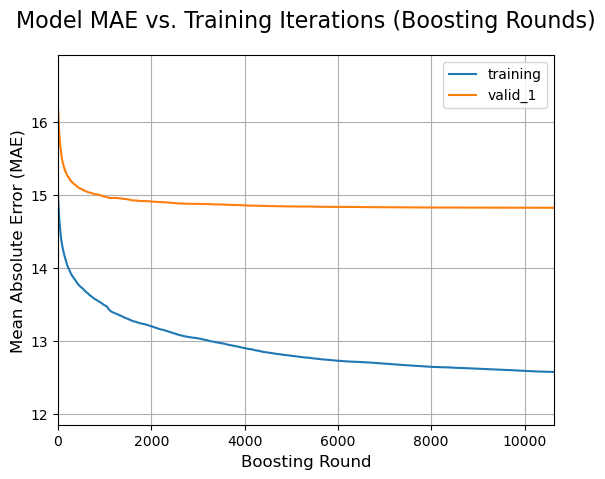

In [118]:
# ==============================================================================
# BLOCK: Plotting Metric (Loss) Curve (Corrected)
# ==============================================================================
import matplotlib.pyplot as plt

print("Plotting training and validation metrics...")

# --- THIS IS THE CHANGE ---
# Remove the metric='mae' argument. 
# The function will find it inside the dictionary.
ax = lgb.plot_metric(evals_result)
# --- END CHANGE ---

plt.title('Model MAE vs. Training Iterations (Boosting Rounds)', fontsize=16, pad=20)
plt.xlabel('Boosting Round', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.show()

--- RESULTS (Test Set) ---
Baseline MAE: 16.21 seconds
Full Model MAE: 14.82 seconds
Improvement:  8.56% reduction in error

--- Key Drivers of Variance (Full Model) ---
                     Feature     Importance
19                SegmentKey  588403.271541
5               dwell_prev_s  277947.654429
11                 headway_s  177788.725079
0                 distance_m  176841.544512
10                momentum_s  169204.157369
9          dwell_prev_prev_s  157088.643773
13          feat_last_trip_s  145819.719158
12  network_congestion_index  141736.442501
15            temperature_2m  128260.854235
8                E_prev_prev  126907.851158

Training REDUCED 'Normal' Model (for comparison)...
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2718]	valid_0's l1: 15.0682


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/3798099097.py:47: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_variance = df_ml[mask_train].groupby("SegmentKey")["link_s"].std().rename("segment_sigma")


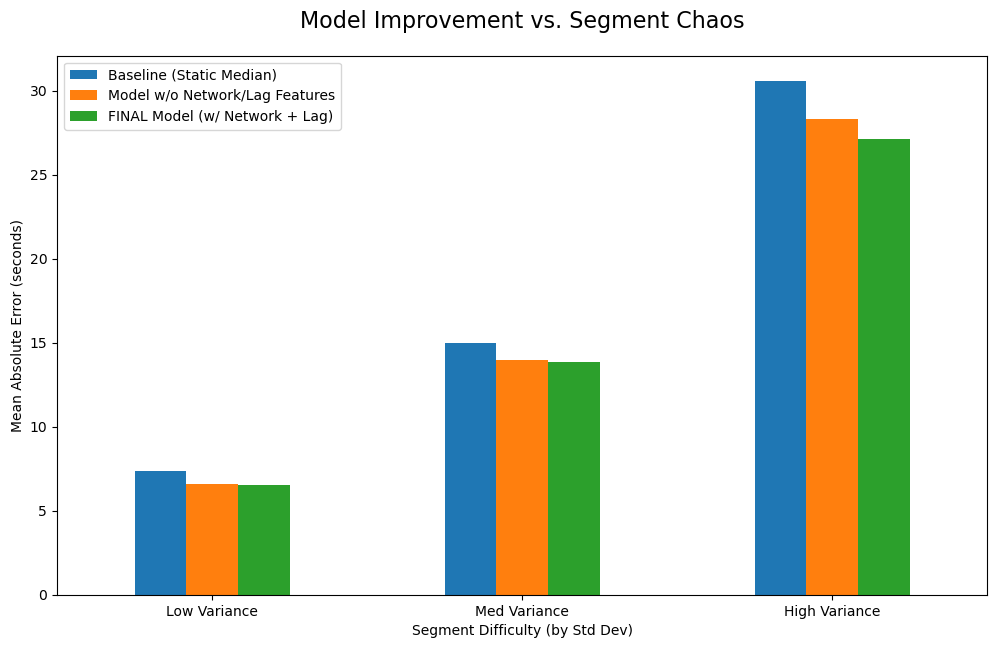

In [119]:
# ==============================================================================
# BLOCK 4 & 6: Evaluation & "Hero Feature" Plot
# ==============================================================================

# 1. Generate Predictions from FULL model
pred_residual = bst.predict(X_test, num_iteration=bst.best_iteration)
df_eval = df_ml[mask_test].copy()
df_eval["pred_total"]    = df_eval["bl_median"] + pred_residual
df_eval["actual_total"]  = df_eval["link_s"]
df_eval["err_baseline"] = (df_eval["actual_total"] - df_eval["bl_median"]).abs()
df_eval["err_model"]    = (df_eval["actual_total"] - df_eval["pred_total"]).abs()

# 2. Metrics for FULL model
mae_baseline = df_eval["err_baseline"].mean()
mae_model    = df_eval["err_model"].mean()
print(f"--- RESULTS (Test Set) ---")
print(f"Baseline MAE: {mae_baseline:.2f} seconds")
print(f"Full Model MAE: {mae_model:.2f} seconds")
print(f"Improvement:  {1 - (mae_model/mae_baseline):.2%} reduction in error")

# 3. Feature Importance for FULL model
importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": bst.feature_importance(importance_type="gain")
}).sort_values(by="Importance", ascending=False)
print("\n--- Key Drivers of Variance (Full Model) ---")
print(importance.head(10))

# --- 4. Train the "Reduced" Model (for comparison) ---
print("\nTraining REDUCED 'Normal' Model (for comparison)...")
X_train_reduced = X_train[features_reduced + cat_cols_reduced]
X_test_reduced = X_test[features_reduced + cat_cols_reduced]
dtrain_reduced = lgb.Dataset(X_train_reduced, label=y_train, categorical_feature=cat_cols_reduced)
bst_reduced = lgb.train(
    params, dtrain_reduced,
    num_boost_round=3000, # Faster training
    valid_sets=[lgb.Dataset(X_test_reduced, label=y_test)],
    callbacks=[lgb.early_stopping(30), lgb.log_evaluation(0)]
)

# 5. Get predictions from the Reduced Model
pred_residual_reduced = bst_reduced.predict(X_test_reduced)
df_eval["pred_reduced_total"] = df_eval["bl_median"] + pred_residual_reduced
df_eval["err_reduced_model"] = (df_eval["actual_total"] - df_eval["pred_reduced_total"]).abs()

# --- 6. Join Variance Data ---
segment_variance = df_ml[mask_train].groupby("SegmentKey")["link_s"].std().rename("segment_sigma")
df_eval_plot = df_eval.join(segment_variance, on="SegmentKey")
bins = [0, 15, 45, 9999]
labels = ["Low Variance", "Med Variance", "High Variance"]
df_eval_plot["variance_bucket"] = pd.cut(df_eval_plot["segment_sigma"], bins=bins, labels=labels)

# --- 7. Plot the "Hero" Bar Chart (Absolute) ---
df_comparison = df_eval_plot.groupby("variance_bucket", as_index=False, observed=True).agg(
    Baseline_MAE=("err_baseline", "mean"),
    Reduced_Model_MAE=("err_reduced_model", "mean"),
    Full_Model_MAE=("err_model", "mean")
)
df_comparison.plot(x="variance_bucket", kind="bar", figsize=(12, 7), rot=0)
plt.ylabel("Mean Absolute Error (seconds)")
plt.xlabel("Segment Difficulty (by Std Dev)")
plt.title("Model Improvement vs. Segment Chaos", fontsize=16, pad=20)
plt.legend([
    "Baseline (Static Median)",
    "Model w/o Network/Lag Features",
    "FINAL Model (w/ Network + Lag)"
])
plt.show()

In [120]:
# Calculate error for both methods
df_eval["err_baseline"] = (df_eval["actual_total"] - df_eval["bl_median"]).abs()
df_eval["err_model"]    = (df_eval["actual_total"] - df_eval["pred_total"]).abs()

# Define "Chaos" scenarios (e.g., actual time is 50% longer than median)
df_chaos = df_eval[df_eval["actual_total"] > 1.5 * df_eval["bl_median"]].copy()

print(f"--- RESULTS ON DELAYED SEGMENTS ONLY ({len(df_chaos)} rows) ---")
mae_base_chaos = df_chaos["err_baseline"].mean()
mae_model_chaos = df_chaos["err_model"].mean()

print(f"Baseline MAE (Chaos): {mae_base_chaos:.2f} s")
print(f"Model MAE (Chaos):    {mae_model_chaos:.2f} s")
print(f"Improvement:          {1 - (mae_model_chaos/mae_base_chaos):.2%}")

--- RESULTS ON DELAYED SEGMENTS ONLY (12913 rows) ---
Baseline MAE (Chaos): 89.50 s
Model MAE (Chaos):    71.60 s
Improvement:          20.00%


In [121]:
# ==============================================================================
# BLOCK: Variance Stress Test (The "Value Add" Proof)
# ==============================================================================

# 1. Calculate "Chaos Factor" (Std Dev) for each segment based on TRAINING data
#    (We use Train to avoid leakage - we predict how hard a segment IS, not how hard it WAS)
segment_variance = df_ml[mask_train].groupby("SegmentKey")["link_s"].std().rename("segment_sigma")

# 2. Join this metadata to your EVALUATION set (Test set)
#    (Make sure df_eval is from the previous Block 4 step)
df_stress = df_eval.join(segment_variance, on="SegmentKey")

# 3. Create Variance Buckets
#    Low:   Sigma < 15s  (Clockwork segments, bus lanes)
#    Med:   15s - 45s    (Normal city traffic)
#    High:  Sigma > 45s  (Problem areas, mixed traffic, heavy boarding)
bins = [0, 15, 45, 9999]
labels = ["Low Variance (Easy)", "Med Variance", "High Variance (Chaos)"]
df_stress["variance_bucket"] = pd.cut(df_stress["segment_sigma"], bins=bins, labels=labels)

# 4. Compute MAE Improvement per Bucket
results = []

for bucket in labels:
    subset = df_stress[df_stress["variance_bucket"] == bucket]
    
    if len(subset) == 0:
        continue
        
    mae_base = mean_absolute_error(subset["actual_total"], subset["bl_median"])
    mae_ml   = mean_absolute_error(subset["actual_total"], subset["pred_total"])
    improv   = 1 - (mae_ml / mae_base)
    
    results.append({
        "Bucket": bucket,
        "N_Samples": len(subset),
        "MAE_Base": f"{mae_base:.2f}s",
        "MAE_Model": f"{mae_ml:.2f}s",
        "Improvement": f"{improv:.2%}"
    })

# 5. Display the "Money Shot" Table
stress_test_df = pd.DataFrame(results)
print("\n--- PERFORMANCE BY SEGMENT DIFFICULTY ---")
print(stress_test_df.to_string(index=False))

# 6. Check the "Super High" Chaos (Top 1% of difficult segments)
high_chaos_sigma = df_stress["segment_sigma"].quantile(0.95)
subset_extreme = df_stress[df_stress["segment_sigma"] > high_chaos_sigma]
mae_base_ex = mean_absolute_error(subset_extreme["actual_total"], subset_extreme["bl_median"])
mae_ml_ex   = mean_absolute_error(subset_extreme["actual_total"], subset_extreme["pred_total"])

print(f"\n--- EXTREME CHAOS (Top 5% hardest segments, sigma > {high_chaos_sigma:.1f}s) ---")
print(f"Baseline MAE: {mae_base_ex:.2f} s")
print(f"Model MAE:    {mae_ml_ex:.2f} s")
print(f"Improvement:  {1 - (mae_ml_ex/mae_base_ex):.2%} <-- This is your selling point")

/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/3631401809.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_variance = df_ml[mask_train].groupby("SegmentKey")["link_s"].std().rename("segment_sigma")



--- PERFORMANCE BY SEGMENT DIFFICULTY ---
               Bucket  N_Samples MAE_Base MAE_Model Improvement
  Low Variance (Easy)      27661    7.35s     6.54s      10.94%
         Med Variance     234789   14.97s    13.83s       7.57%
High Variance (Chaos)      37090   30.54s    27.11s      11.23%

--- EXTREME CHAOS (Top 5% hardest segments, sigma > 61.6s) ---
Baseline MAE: 39.12 s
Model MAE:    34.68 s
Improvement:  11.37% <-- This is your selling point


In [122]:
# ==============================================================================
# BLOCK 5 (V3): Calculating NORMALIZED Metrics
# ==============================================================================
import numpy as np

# 1. Calculate Cv (Normalized Difficulty) from TRAINING data
print("Calculating normalized metrics (Cv, MAPE)...")
train_stats = df_ml[mask_train].groupby("SegmentKey")["link_s"].agg(
    mu='mean',
    sigma='std'
)
train_stats["Cv"] = train_stats["sigma"] / train_stats["mu"]

# 2. Join Cv to your evaluation dataframe
df_eval_norm = df_eval_plot.join(train_stats["Cv"], on="SegmentKey")
# Handle division by zero or NaNs
df_eval_norm["Cv"] = df_eval_norm["Cv"].fillna(0).replace([np.inf, -np.inf], 0)

# 3. Calculate MAPE (Normalized Error) for all models
# (Avoid division by zero if actual_total is 0, though QC should prevent this)
df_eval_norm["err_baseline_mape"] = (
    df_eval_norm["err_baseline"] / df_eval_norm["actual_total"]
).replace([np.inf, -np.inf], 0)

df_eval_norm["err_reduced_mape"] = (
    df_eval_norm["err_reduced_model"] / df_eval_norm["actual_total"]
).replace([np.inf, -np.inf], 0)

df_eval_norm["err_model_mape"] = (
    df_eval_norm["err_model"] / df_eval_norm["actual_total"]
).replace([np.inf, -np.inf], 0)

print("Normalized metrics ready.")

Calculating normalized metrics (Cv, MAPE)...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/3413077157.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_stats = df_ml[mask_train].groupby("SegmentKey")["link_s"].agg(


Normalized metrics ready.


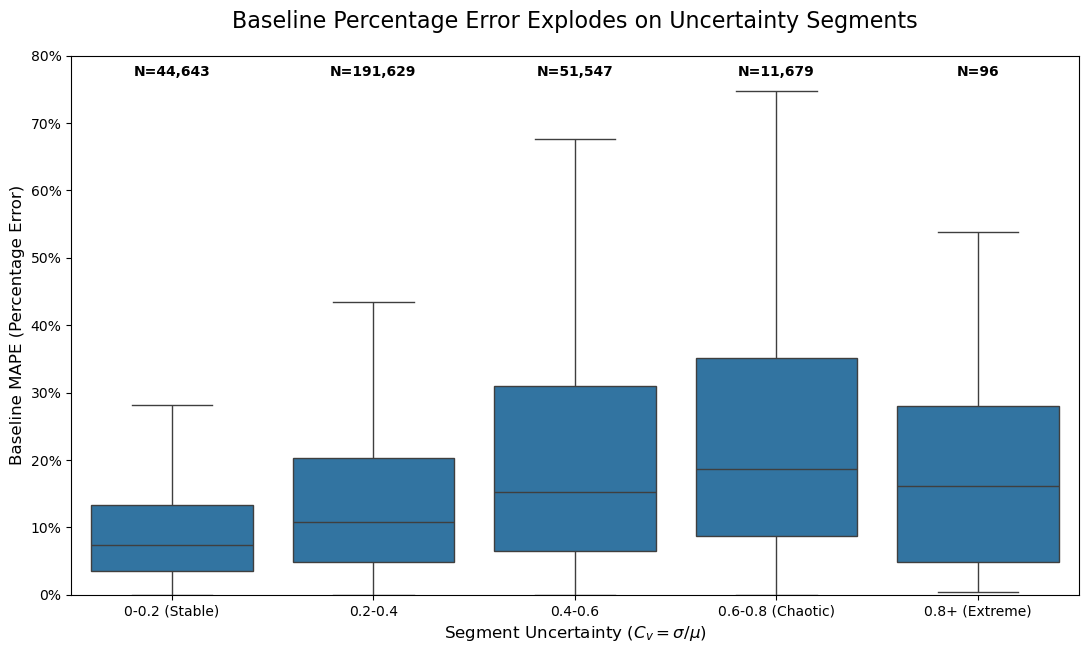

In [123]:
# ==============================================================================
# BLOCK 5 (V4): FINAL PLOT 1 - Normalized Error vs. Cv
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns


bins = [0, 0.2, 0.4, 0.6, 0.8, df_eval_norm["Cv"].max() + 1]
labels = ["0-0.2 (Stable)", "0.2-0.4", "0.4-0.6", "0.6-0.8 (Chaotic)", "0.8+ (Extreme)"]

df_eval_norm["Cv_bin"] = pd.cut(
    df_eval_norm["Cv"], 
    bins=bins, 
    labels=labels, 
    right=False
)

# 1. Calculate Counts per Cv Bin (Ensures correct order)
#    We use the same bins/labels defined in the previous step (0-0.2, 0.2-0.4, etc.)
bin_counts = df_eval_norm["Cv_bin"].value_counts().sort_index()

plt.figure(figsize=(13, 7))
ax = sns.boxplot(
    x="Cv_bin",
    y="err_baseline_mape",
    data=df_eval_norm,
    showfliers=False, # Hide extreme outliers (e.g., 500% error)
    order=df_eval_norm["Cv_bin"].cat.categories # Ensure bins are plotted in order
)

# 2. Add Count Annotations (N=count)
for i, count in enumerate(bin_counts):
    # Position text just above the max Y-value (using 0.3 as a safe high point for % error)
    # We ignore the label for the empty bin (if N=0)
    if count > 0:
        ax.text(
            i, 
            0.77, # Consistent high Y-value (e.g., 38% for positioning)
            f"N={count:,}", 
            color='black', 
            ha="center", 
            weight='bold', 
            fontsize=10
        )

# 3. Final Formatting
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}')) # Format Y-axis as %
plt.ylim(0, 0.80) # Zoom in to 60% error to show the box structures clearly
plt.xlabel("Segment Uncertainty ($C_v = \\sigma / \\mu$)", fontsize=12)
plt.ylabel("Baseline MAPE (Percentage Error)", fontsize=12)
plt.title("Baseline Percentage Error Explodes on Uncertainty Segments", fontsize=16, pad=20)
plt.show()

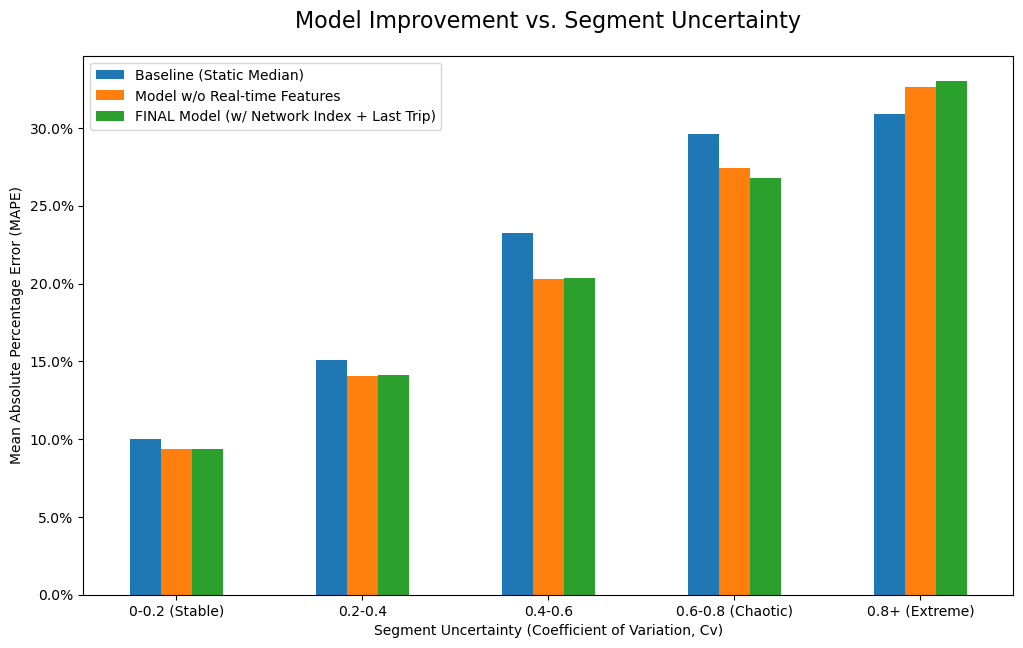

In [124]:
# ==============================================================================
# BLOCK 6 (V3): PLOT 2 - Normalized "Hero Feature" Value
# ==============================================================================

# 1. Group by Cv_bin and get MAPE for all 3 models
df_norm_comparison = df_eval_norm.groupby("Cv_bin", as_index=False, observed=True).agg(
    Baseline_MAPE=("err_baseline_mape", "mean"),
    Reduced_Model_MAPE=("err_reduced_mape", "mean"),
    Full_Model_MAPE=("err_model_mape", "mean")
)


# 2. Plot the Bar Chart
df_norm_comparison.plot(x="Cv_bin", kind="bar", figsize=(12, 7), rot=0)
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.xlabel("Segment Uncertainty (Coefficient of Variation, Cv)")
plt.title("Model Improvement vs. Segment Uncertainty", fontsize=16, pad=20)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))
plt.legend([
    "Baseline (Static Median)",
    "Model w/o Real-time Features",
    "FINAL Model (w/ Network Index + Last Trip)"
])
plt.show()

In [126]:
pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
Note: you may need to restart the kernel to use updated packages.


In [128]:
# ==============================================================================
# BLOCK: Sampling "Typical Conservative Failures" for Presentation
# ==============================================================================

# 1. Create a dataframe for sampling.
df_samples = df_eval.copy()

# 2. Define the "Conservative Error"
df_samples["err_under_prediction"] = df_samples["actual_total"] - df_samples["pred_total"]

# 3. Define a "Chaos Event"
df_samples["is_chaos_event"] = df_samples["actual_total"] > (df_samples["bl_median"] * 1.5)

# 4. Filter for the "Typical Smoking Guns"
#    - Where a chaos event happened
#    - AND our model under-predicted by a *significant but not extreme* amount
#      (Let's define this as between 30 and 90 seconds)
typical_failures = df_samples[
    (df_samples["is_chaos_event"] == True) &
    (df_samples["err_under_prediction"].between(30, 90)) # <--- KEY CHANGE
]

# 5. Sort by the worst of these "typical" failures
typical_failures = typical_failures.sort_values(by="err_under_prediction", ascending=False)

# 6. Display the columns you will put in your slide
cols_to_show = [
    "SegmentKey", 
    "link_start_time", 
    "actual_total",  # The Ground Truth
    "bl_median",     # The "Normal" Time
    "pred_total",    # The Model's "Safe" Guess
    "err_under_prediction"
]

print("--- Top 10 Typical Conservative Failures (30-90s Error) ---")
print(typical_failures[cols_to_show].head(10).to_markdown(index=False, floatfmt=".1f"))

--- Top 10 Typical Conservative Failures (30-90s Error) ---
| SegmentKey    | link_start_time     |   actual_total |   bl_median |   pred_total |   err_under_prediction |
|:--------------|:--------------------|---------------:|------------:|-------------:|-----------------------:|
| CAMA01→ANCI01 | 2024-12-02 17:59:46 |          190.0 |        96.0 |        100.0 |                   90.0 |
| PLDI01→STND01 | 2024-12-19 08:57:02 |          209.0 |       126.0 |        119.0 |                   90.0 |
| ARAR01→VELO01 | 2024-12-05 17:18:38 |          228.0 |        81.0 |        138.0 |                   90.0 |
| STND03→PLDI00 | 2024-12-06 16:41:55 |          271.0 |       164.0 |        181.0 |                   90.0 |
| STGE00→BHET05 | 2024-12-17 07:17:55 |          181.0 |        93.0 |         91.0 |                   90.0 |
| PLOU01→AVIA01 | 2024-12-16 14:11:43 |          186.0 |        94.5 |         96.0 |                   90.0 |
| AVIA00→PLOU00 | 2024-12-19 11:37:48 |          139

In [107]:
# ==============================================================================
# BLOCK: Baseline Ladder Comparison (Focused & Consistent)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Calculate Baselines L0, L1, L2, L3 (using MEDIAN for all)
print("Calculating consistent baselines using 'median'...")
l0_global_median = df_ml[mask_train]["link_s"].median() # Changed to median
l1_segment_median = df_ml[mask_train].groupby("SegmentKey")["link_s"].median().rename("bl_l1_median") # Changed
l2_segment_dow = df_ml[mask_train].groupby(["SegmentKey", "dow"])["link_s"].median().rename("bl_l2_dow_median") # Changed
# L3 (your baseline) is already using median
l3_segment_hour = df_ml[mask_train].groupby(["SegmentKey", "period168"])["link_s"].median().rename("bl_l3_hour_median")

print(f"L0 Global Median: {l0_global_median:.2f}s")

# 2. Map all baselines to the Test Set (df_eval_norm)
df_eval_norm["bl_l0_pred"] = l0_global_median # Use L0 median

# --- Use .map() and force float dtype ---
df_eval_norm["bl_l1_median"] = df_eval_norm["SegmentKey"].map(l1_segment_median).astype(float)
df_eval_norm["bl_l2_dow_median"] = df_eval_norm.set_index(["SegmentKey", "dow"]).index.map(l2_segment_dow).astype(float)

# 3. Handle fallbacks (a "waterfall" of logic)
df_eval_norm["bl_l1_median"] = df_eval_norm["bl_l1_median"].fillna(l0_global_median)
df_eval_norm["bl_l2_dow_median"] = df_eval_norm["bl_l2_dow_median"].fillna(df_eval_norm["bl_l1_median"])
# (Your main baseline 'bl_median' (L3) already has its own fallback, so it's fine)

# 4. Calculate MAPE for L0, L1, and L2
#    (L3's MAPE 'err_baseline_mape' is already calculated)
df_eval_norm["err_l0_mape"] = (
    (df_eval_norm["bl_l0_pred"] - df_eval_norm["actual_total"]).abs() / df_eval_norm["actual_total"]
).replace([np.inf, -np.inf], 0)

df_eval_norm["err_l1_mape"] = (
    (df_eval_norm["bl_l1_median"] - df_eval_norm["actual_total"]).abs() / df_eval_norm["actual_total"]
).replace([np.inf, -np.inf], 0)

df_eval_norm["err_l2_mape"] = (
    (df_eval_norm["bl_l2_dow_median"] - df_eval_norm["actual_total"]).abs() / df_eval_norm["actual_total"]
).replace([np.inf, -np.inf], 0)

# 5. Gather all baseline MAPE scores
mape_scores = {
    "Model": [
        "L0: Global Median", 
        "L1: Segment Median", 
        "L2: Segment + Weekday", 
        "L3: Segment + Weekhour"
    ],
    "MAPE": [
        df_eval_norm["err_l0_mape"].mean(),
        df_eval_norm["err_l1_mape"].mean(),
        df_eval_norm["err_l2_mape"].mean(),
        df_eval_norm["err_baseline_mape"].mean(), # This is your L3
    ]
}
df_mape_scores = pd.DataFrame(mape_scores)

# 6. Calculate MAE for L0, L1, L2
df_eval_norm["err_l0_mae"] = (df_eval_norm["bl_l0_pred"] - df_eval_norm["actual_total"]).abs()
df_eval_norm["err_l1_mae"] = (df_eval_norm["bl_l1_median"] - df_eval_norm["actual_total"]).abs()
df_eval_norm["err_l2_mae"] = (df_eval_norm["bl_l2_dow_median"] - df_eval_norm["actual_total"]).abs()

# 7. Gather all baseline MAE scores
mae_scores = {
    "Model": [
        "L0: Global Median", 
        "L1: Segment Median", 
        "L2: Segment + Weekday", 
        "L3: Segment + Weekhour"
    ],
    "MAE": [
        df_eval_norm["err_l0_mae"].mean(),
        df_eval_norm["err_l1_mae"].mean(),
        df_eval_norm["err_l2_mae"].mean(),
        df_eval_norm["err_baseline"].mean(), # This is your L3 MAE
    ]
}
df_mae_scores = pd.DataFrame(mae_scores)

print("Baseline ladder dataframes (df_mape_scores, df_mae_scores) are ready.")

Calculating consistent baselines using 'median'...


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/2040916622.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  l1_segment_median = df_ml[mask_train].groupby("SegmentKey")["link_s"].median().rename("bl_l1_median") # Changed
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/2040916622.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  l2_segment_dow = df_ml[mask_train].groupby(["SegmentKey", "dow"])["link_s"].median().rename("bl_l2_dow_median") # Changed
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/2040916622.py:13: FutureWarning: The default of observed=Fa

L0 Global Median: 90.00s
Baseline ladder dataframes (df_mape_scores, df_mae_scores) are ready.


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/3156292322.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=mae_values, ax=ax1, palette="viridis", alpha=0.7)
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_50194/3156292322.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)


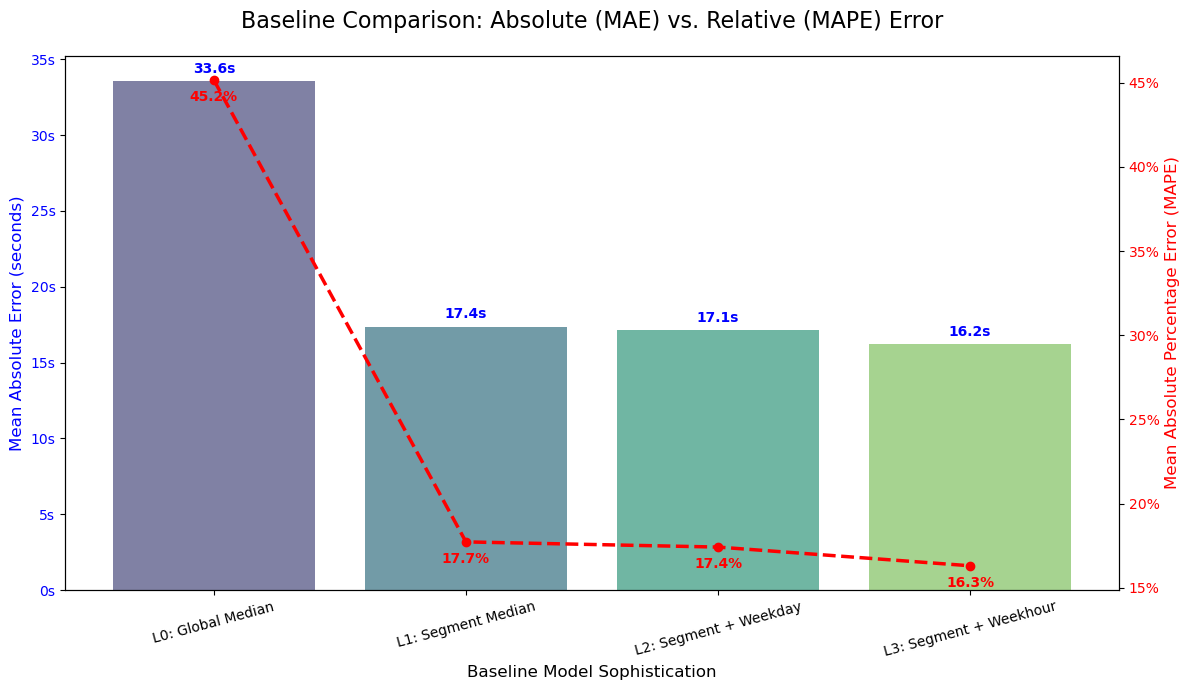

In [108]:
# ==============================================================================
# BLOCK: Baseline Ladder Comparison (Dual Axis)
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the data from the previous dataframes
models = df_mae_scores["Model"]
mae_values = df_mae_scores["MAE"]
mape_values = df_mape_scores["MAPE"]

# 2. Create the figure and the primary axis (ax1) for MAE
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot the MAE (Absolute Error) as a bar chart on ax1
sns.barplot(x=models, y=mae_values, ax=ax1, palette="viridis", alpha=0.7)
ax1.set_ylabel("Mean Absolute Error (seconds)", fontsize=12, color='blue')
ax1.set_xlabel("Baseline Model Sophistication", fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15)

# 3. Create the secondary axis (ax2) for MAPE
ax2 = ax1.twinx() 

# Plot the MAPE (Percentage Error) as a line chart on ax2
ax2.plot(models, mape_values, color='red', marker='o', linestyle='--', linewidth=2.5, label='MAPE')
ax2.set_ylabel("Mean Absolute Percentage Error (MAPE)", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 4. Format the Y-axes
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}s'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Add labels to the bar chart (MAE)
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.1f}s", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                weight='bold', color='blue')

# Add labels to the line chart (MAPE)
for i, txt in enumerate(mape_values):
    ax2.annotate(f"{txt:.1%}", (models[i], mape_values[i]),
                 textcoords="offset points", 
                 xytext=(0, -15), # Offset below the marker
                 ha='center', color='red', weight='bold')


plt.title("Baseline Comparison: Absolute (MAE) vs. Relative (MAPE) Error", fontsize=16, pad=20)
fig.tight_layout() # Adjust layout to prevent label overlap
plt.show()

In [35]:
# ==============================================================================
# BLOCK: Quantile Regression (Predicting Risk / P85)
# ==============================================================================

# 1. Update Parameters for Quantile Loss
#    We want the model to penalize "under-prediction" 6x more than "over-prediction"
#    (Because alpha = 0.85 approx 85/15 ratio)
params_p85 = {
    "objective": "quantile",
    "alpha": 0.85,  # <--- THE MAGIC NUMBER
    "metric": "quantile",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "verbose": -1
}

# 2. Train the P85 Model
#    (We use the exact same dtrain/dtest as before)
print("Training LightGBM P85 Model...")
bst_p85 = lgb.train(
    params_p85,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dtest],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50), 
        lgb.log_evaluation(100)
    ]
)

# 3. Generate P85 Predictions (Residuals)
pred_residual_p85 = bst_p85.predict(X_test, num_iteration=bst_p85.best_iteration)

# 4. Construct the Total P85 Prediction
#    Note: Ideally, we should add this to the *Baseline P85*, not Baseline Median.
#    BUT: Since your model learns the *residual*, adding it to the median is mathematically 
#    approximating "Median + P85_Residual". 
#    
#    BETTER APPROACH for P85: 
#    Let's calculate the ACTUAL Empirical P85 from training to serve as the baseline.

# Recalculate Baseline P85 (Static)
baseline_p85_lookup = df_ml[mask_train].groupby(["SegmentKey", "period168"])["link_s"].quantile(0.85).rename("bl_p85")
df_eval_risk = df_eval.join(baseline_p85_lookup, on=["SegmentKey", "period168"])

# Fallback for missing P85 (Global P85 per segment)
fallback_p85 = df_ml[mask_train].groupby("SegmentKey")["link_s"].quantile(0.85).rename("bl_p85_fallback")
df_eval_risk = df_eval_risk.join(fallback_p85, on="SegmentKey")
df_eval_risk["bl_p85"] = df_eval_risk["bl_p85"].fillna(df_eval_risk["bl_p85_fallback"])

# Now construct the Dynamic P85 Prediction
# We train the model to predict (Actual - Baseline_Median). 
# So: Pred_P85_Total = Baseline_Median + Model_P85_Output
df_eval_risk["pred_p85_total"] = df_eval_risk["bl_median"] + pred_residual_p85

Training LightGBM P85 Model...
Training until validation scores don't improve for 50 rounds
[100]	training's quantile: 5.30128	valid_1's quantile: 5.6182
[200]	training's quantile: 5.21417	valid_1's quantile: 5.55357
[300]	training's quantile: 5.17252	valid_1's quantile: 5.53095
[400]	training's quantile: 5.14203	valid_1's quantile: 5.52349
[500]	training's quantile: 5.11846	valid_1's quantile: 5.51637
[600]	training's quantile: 5.07777	valid_1's quantile: 5.51082
Early stopping, best iteration is:
[564]	training's quantile: 5.08808	valid_1's quantile: 5.51002


/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_20867/1136760510.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline_p85_lookup = df_ml[mask_train].groupby(["SegmentKey", "period168"])["link_s"].quantile(0.85).rename("bl_p85")
/var/folders/p6/pb4fxjzn3r3b73xfyn72rzr00000gn/T/ipykernel_20867/1136760510.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fallback_p85 = df_ml[mask_train].groupby("SegmentKey")["link_s"].quantile(0.85).rename("bl_p85_fallback")


In [36]:
# ==============================================================================
# BLOCK: Risk Model Evaluation
# ==============================================================================

# 1. Coverage Check
#    Does your P85 actually capture 85% of trips?
actual_below_static = (df_eval_risk["actual_total"] <= df_eval_risk["bl_p85"]).mean()
actual_below_dynamic = (df_eval_risk["actual_total"] <= df_eval_risk["pred_p85_total"]).mean()

print(f"--- RELIABILITY (Target: ~85%) ---")
print(f"Static P85 Coverage:  {actual_below_static:.2%} of trips inside bounds")
print(f"Dynamic P85 Coverage: {actual_below_dynamic:.2%} of trips inside bounds")

# 2. The "Buffer Squeeze" (Efficiency)
#    How wide is the safety margin? (Smaller is better IF coverage is maintained)
df_eval_risk["static_buffer"] = df_eval_risk["bl_p85"] - df_eval_risk["bl_median"]
df_eval_risk["dynamic_buffer"] = df_eval_risk["pred_p85_total"] - df_eval_risk["bl_median"]

avg_stat_buf = df_eval_risk["static_buffer"].mean()
avg_dyn_buf = df_eval_risk["dynamic_buffer"].mean()

print(f"\n--- EFFICIENCY (Average Safety Margin) ---")
print(f"Static Buffer:  {avg_stat_buf:.2f} seconds")
print(f"Dynamic Buffer: {avg_dyn_buf:.2f} seconds")
print(f"Reduction:      {1 - (avg_dyn_buf/avg_stat_buf):.2%} tighter intervals (time saved for scheduling)")

# 3. The "Chaos Response"
#    Does the Dynamic P85 react to High Variance segments?
print("\n--- ADAPTABILITY IN CHAOS (High Variance Segments) ---")
mask_chaos = df_stress["variance_bucket"] == "High Variance (Chaos)"
subset_chaos = df_eval_risk[mask_chaos]

# Compare coverage in chaos
chaos_cov_static = (subset_chaos["actual_total"] <= subset_chaos["bl_p85"]).mean()
chaos_cov_dynamic = (subset_chaos["actual_total"] <= subset_chaos["pred_p85_total"]).mean()

print(f"Static Coverage in Chaos:  {chaos_cov_static:.2%} (Usually drops below 85% - unsafe)")
print(f"Dynamic Coverage in Chaos: {chaos_cov_dynamic:.2%} (Should stay near 85% - safe)")

--- RELIABILITY (Target: ~85%) ---
Static P85 Coverage:  83.90% of trips inside bounds
Dynamic P85 Coverage: 84.49% of trips inside bounds

--- EFFICIENCY (Average Safety Margin) ---
Static Buffer:  20.82 seconds
Dynamic Buffer: 19.68 seconds
Reduction:      5.46% tighter intervals (time saved for scheduling)

--- ADAPTABILITY IN CHAOS (High Variance Segments) ---
Static Coverage in Chaos:  83.45% (Usually drops below 85% - unsafe)
Dynamic Coverage in Chaos: 84.34% (Should stay near 85% - safe)
